# RES Cleaning

This notebook walks through how the RES articles were sorted into categories of articles and non-articles.

## Load Libraries

In [1]:
from tokenize import Ignore
import pandas as pd
import time
from os import path
import sys
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import os
from difflib import SequenceMatcher
import datetime
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 200)    

## Load Files

Replace the file paths below to match local file paths. Note: comment out files that are not available eg: datadumps.

In [2]:
base_path="/Users/sijiawu/Work/Thesis/Data"

In [3]:
masters = pd.read_excel(base_path+"/Masterlists/RESTUD_Masterlist.xlsx")
masters10 = pd.read_excel(base_path+ "/2010/RESTUD_master.xlsx")
pivots = pd.read_excel(base_path+"/Pivots/RESTUD_Pivots2020.xlsx")

## Create File Names

In [4]:
saveas=base_path+"/Processed/RES_processed.xlsx"

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [5]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

,count
title,
front matter,303
back matter,284
volume information,73
accepted manuscripts,9
books and monographs received,8
periodicals received,8
editorial announcement,8
editorial,5
comment,5


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [6]:
temp1=masters[masters['author'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

,count
title,
front matter,303
back matter,284
volume information,73
accepted manuscripts,9
periodicals received,8
books and monographs received,8
announcement,3
books and periodicals received,3
introduction,2


In [7]:
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'

# this is a random panel for testing code
masters[masters["title"].isna()==True]

,type,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,abstract,author,pages,reviewed-author,uploaded


Notice that titles with duplicates of greater or equal to 4 are miscellaneous items and so they are classified in bulk

In [8]:
temp2=masters['title'].str.lower().value_counts()
removal=list(temp2[temp2>=8].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

## Combine the scraped list with the citations files
This is to rename the fields to differentiate scopus and jstor data fields and drop some miscellaneous columns that are not necessary. There are no reviews in RES (ironically) or atleast what jstor classifies as reviews.

In general, I have found that masterlists contructed from citation files lack the reviewed source's name while it is present on the page of the article. Some files are also just missing the title. So I'm combining the old masterlists with the new ones.

In [9]:
#preprocessing step
pivots['type']=pd.NA
masters["URL"]="https:"+masters["URL"].str.split(':').str[-1]
masters.drop('type', inplace=True, axis=1)
masters10["stable_url"]="https:"+masters10["stable_url"].str.split(':').str[-1]
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = pd.NA  
masters['pages']=masters["pages"].str.split('pp. ').str[-1]
masters['pages']=masters['pages'].replace(r'--','-',regex=True).str.strip()

In [10]:
masters["author_split"]=masters['author'].str.split(' and ')


In [11]:
masters=masters.merge(masters10[['URL', 'title_10']], how='left', on='URL')
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"

Classify some titles via regex

In [12]:
masters.loc[masters['title'].str.lower().str.contains('books and periodicals')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^editorial')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^announcement')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^author index')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^index to volumes.*')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^index$')==True,'content_type']='MISC'
masters.loc[(masters['title'].str.lower().str.match(r'^introduction$')==True)&(masters['author'].isna()==True),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^subject index$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains(r'econometric society')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains(r'periodicals')==True,'content_type']='MISC'

## Classifying other content

In [13]:
sum(masters.content_type.isna())
#masters.shape[0]

3422

In [14]:
masters.loc[masters['author'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.author.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

0

In [15]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?).*comment.*$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*comment$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(a further|further) comment.*$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] 
#comments

60

In [16]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

15

In [17]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?|).*rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]


9

In [18]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]


0

In [19]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

3338

In [20]:
# block for testing regex patterns
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion'].shape[0]

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next code block separates special issues (S) from normal issues (N)

In [21]:
pivots.loc[pivots.Jstor_issue_text.isna(),"Jstor_issue_text"]="None"
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(special issue|symposium|index to volumes|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

type
N    313
S      8
Name: count, dtype: int64

Merge masterlist and pivot list

In [22]:
result = pd.merge(masters, pivots[['issue_url','type']], how="left", on=["issue_url", "issue_url"])

In [23]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [208]:
cleaned=pd.read_excel(saveas)
cleaned.dtypes

issue_url                  object
ISSN                       object
URL                        object
journal                    object
number                     object
publisher                  object
title                      object
urldate            datetime64[ns]
volume                      int64
year                        int64
abstract                   object
author                     object
pages                      object
reviewed-author           float64
uploaded                    int64
content_type               object
author_split               object
title_10                   object
type                       object
dtype: object

In [209]:
scopus.dtypes

authorsSCO          object
titleSCO            object
journalSCO          object
volume             float64
number             float64
year                 int64
pages               object
DOI                 object
affiliations        object
abstractSCO         object
citations           object
document type       object
index keywords      object
author keywords     object
dtype: object

set the types

In [210]:
cleaned['volume']=cleaned['volume'].astype(int)
scopus=scopus[scopus.volume.isna()==False].reset_index(drop =True)
scopus=scopus[scopus.volume!="."].reset_index(drop =True)
scopus['volume']=scopus['volume'].astype(int)

scopus['year']=scopus['year'].astype(int)
cleaned['year']=cleaned['year'].astype(int)

scopus['pages']=scopus['pages'].str.strip()

cleaned['number']=cleaned['number'].astype(str)
scopus=scopus[scopus.number.isna()==False].reset_index(drop =True)
scopus=scopus[(scopus.number!=142)&(scopus.number!=168)].reset_index(drop = True)
scopus['number']=scopus['number'].astype(int)
scopus['number']=scopus['number'].astype(str)


This is the number of entries on Scopus

In [211]:
#Note that we only have data up to 2019 in the masterlists because of the moving wall on JSTOR but additional content was downloaded from the og site
print(sum(scopus['year']<2020))
print(scopus.shape)

2912
(2983, 14)


Merge on year, issue, volume and pages.

In [212]:
Merged=pd.merge(cleaned, scopus, on=['year','number','volume','pages'], how='left')
pd.set_option('display.max_columns', None)

Check how many of the scopus entries matched.

In [213]:
sum(Merged['titleSCO'].isna()==False)

2820

Quick maths: There are 3970 total documents for Review of econ. studies (RES) between, 3180 of these are actual articles. Scopus matched up to 2698 entries in the RES masterlist. This means there is 146 entries in Scopus that do not match up to something in the masterlists. And atleast 1272 entries in the masterlist without scopus records. Conclusion: 60% coverage ain't too bad! Now let's see if there is actual references and affiliations or did Scopus just bullshit us all.

Consider the titles that have a less than 70% match.

In [220]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['titleSCO'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title'].lower(), Merged.iloc[m]['titleSCO'].lower()).ratio()

        if((ratio<=0.9) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if (pd.isna(Merged.iloc[m]['author'])==False)&(pd.isna(Merged.iloc[m]['authorsSCO'])==False):
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['author'].lower(), Merged.iloc[m]['authorsSCO'].lower()).ratio()
                print(A_ratio)
            
            print(Merged.iloc[m]['URL'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['number']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title'])
            print('scopus: '+Merged.iloc[m]['titleSCO'])
            print('jstor: '+str(Merged.iloc[m]['author']))
            print('scopus: '+str(Merged.iloc[m]['authorsSCO']))
            print('scopus index: '+str(scopus[(scopus['titleSCO']==Merged.iloc[m]['titleSCO'])&(scopus['authorsSCO']==Merged.iloc[m]['authorsSCO'])].index))
            print(scopus.loc[(scopus['titleSCO']==Merged.iloc[m]['titleSCO'])&(scopus['authorsSCO']==Merged.iloc[m]['authorsSCO']),"affiliations"])
            print(m)
            print()
print(count)

2017
0.7070707070707071
https://www.jstor.org/stable/26543875
vol: 84
issue: 4
pages: 1869-1869
jstor: Erratum: Pecuniary Externalities in Economies with Financial Frictions
scopus: Erratum: "Pecuniary externalities in economies with financial frictions" [Review of Economic Studies] doi: 10.1093/restud/rdx010
jstor: nan
scopus: Dávila, E., Korinek, A.
scopus index: Index([2635], dtype='int64')
2635    NaN
Name: affiliations, dtype: object
259

2017
0.5547445255474452
https://www.jstor.org/stable/26543876
vol: 84
issue: 4
pages: 1870-1870
jstor: Corrigendum: Signaling Private Choices
scopus: Corrigendum to: "Signaling Private Choices" [Review of Economic Studies] doi: 10.1093/restud/rdx012
jstor: nan
scopus: In, Y., Wright, J.
scopus index: Index([2639], dtype='int64')
2639    NaN
Name: affiliations, dtype: object
260

2013
0.5858585858585859
0.4444444444444444
https://www.jstor.org/stable/43551460
vol: 80
issue: 3
pages: 1178-1214
jstor: Estimating Ethnic Preferences Using Ethnic Housi

This code is used to search for title or author matches in the jstor masterlists to find entries to correct the scopus data.

In [111]:
#search='Bargaining With Two-Sided Incomplete Information: An Infinite Horizon Model With Alternating Offers'
#search='Acyclic choice without the pareto principle'
#search='On Bayesian Implementable Allocations'
#search='How fast do rational agents learn'
search='A. P. lerner'
for i in cleaned.index:
    if pd.isna(cleaned.iloc[i]['authors'])==False:
        c=SequenceMatcher(None, cleaned.iloc[i]['authors'].lower(), search).ratio()
        if c>0.7:
            print(cleaned.iloc[i])

Now let's do some manual corrections.

In [215]:

#scopus index 1170 wrong citation altogether in scopus drop from scopus set

#these recorded incorrect pages
scopus.loc[1243,'pages']='693-699 '
scopus.loc[1496,'pages']='175-192'

scopus.loc[1494,'pages']='193-208'
scopus.loc[1599, 'pages']='329-347'

scopus.loc[1162,'pages']="389-391"
scopus.loc[949, 'titleSCO']="The Optimal Linear Income-tax"
scopus.drop(1244, axis=0, inplace=True) #uncomment later for full run

Re-merge the scopus data and the cleaned masterlists

In [216]:
Merged=pd.merge(cleaned, scopus, on=['year', 'number','volume','pages'], how='left')

Check for whether there is an issue in document type and correct it.

In [218]:
pd.DataFrame(Merged[Merged['document type'].str.len()>100])
Merged.loc[340,'document_type']='Article'
Merged.loc[344,'document_type']='Article'

saving...

In [175]:
Merged.to_excel(base_path+'/Combined/RES_M_sco_du.xlsx', index=False)

# Merged dataset field description

This is a description of fields in the Merged dataset that combines JPE masterlist, pivot list, Scopus data pre-2018. The Merged dataset is stored in RES_M_sco_du.xlsx. Note that RES does not contain any reference data scraped from JSTOR.

    'stable_url' : JSTOR url for article 
    'Jstor_authors' : Author names recorded by JSTOR
    'Jstor_title' : Title of article recorded by JSTOR
    'Jstor_abstract' : abstract recorded by JSTOR nb: this is blank at the moment
    'content_type' : Article type determined during cleaning. Includes MISC for miscellaneous, Reviews, Note, Comment, Rejoinder and Article categorizations
    'issue_url' : url of issue article belongs to on JSTOR
    'pages' : pages as recorded by JSTOR
    'year' : Year of publication recorded by JSTOR
    'volume' : Volume of article recorded by JSTOR
    'issue' : issue of article recorded by JSTOR
    'Jstor_journal' : journal name JSTOR
    'type' : Type of issue determined during cleaning. S for special issue. N for normal issue
    'scopus_authors' : Author names recorded by Scopus
    'scopus_title' : Title recorded by Scopus
    'scopus_journal' : Journal name recorded by Scopus
    'DOI' : DOI recorded by scopus
    'affiliations' : affiliations of authors as recorded by scopus
    'scopus_abstract' : abstract of article recorded by scopus
    'citations' : citations of article recorded by scopus
    'document type' : Article type recorded by scopus, may differ from that in cleaning
    'index keywords' : from scopus
    'author keywords' : from scopus 

In [4]:
inv=Merged[(Merged['year']<=1971) & (Merged['year']>=1940)&(Merged['content_type']!='MISC')&(Merged['content_type']!='Review')&(Merged['content_type']!='Discussion')]
inv.shape

(805, 24)

In [5]:
Merged.content_type.unique()

array(['MISC', 'Article', 'Comment', 'Reply', 'Rejoinder'], dtype=object)

### Plots of counts
Exploratory analysis of available data in scopus and datadumps.

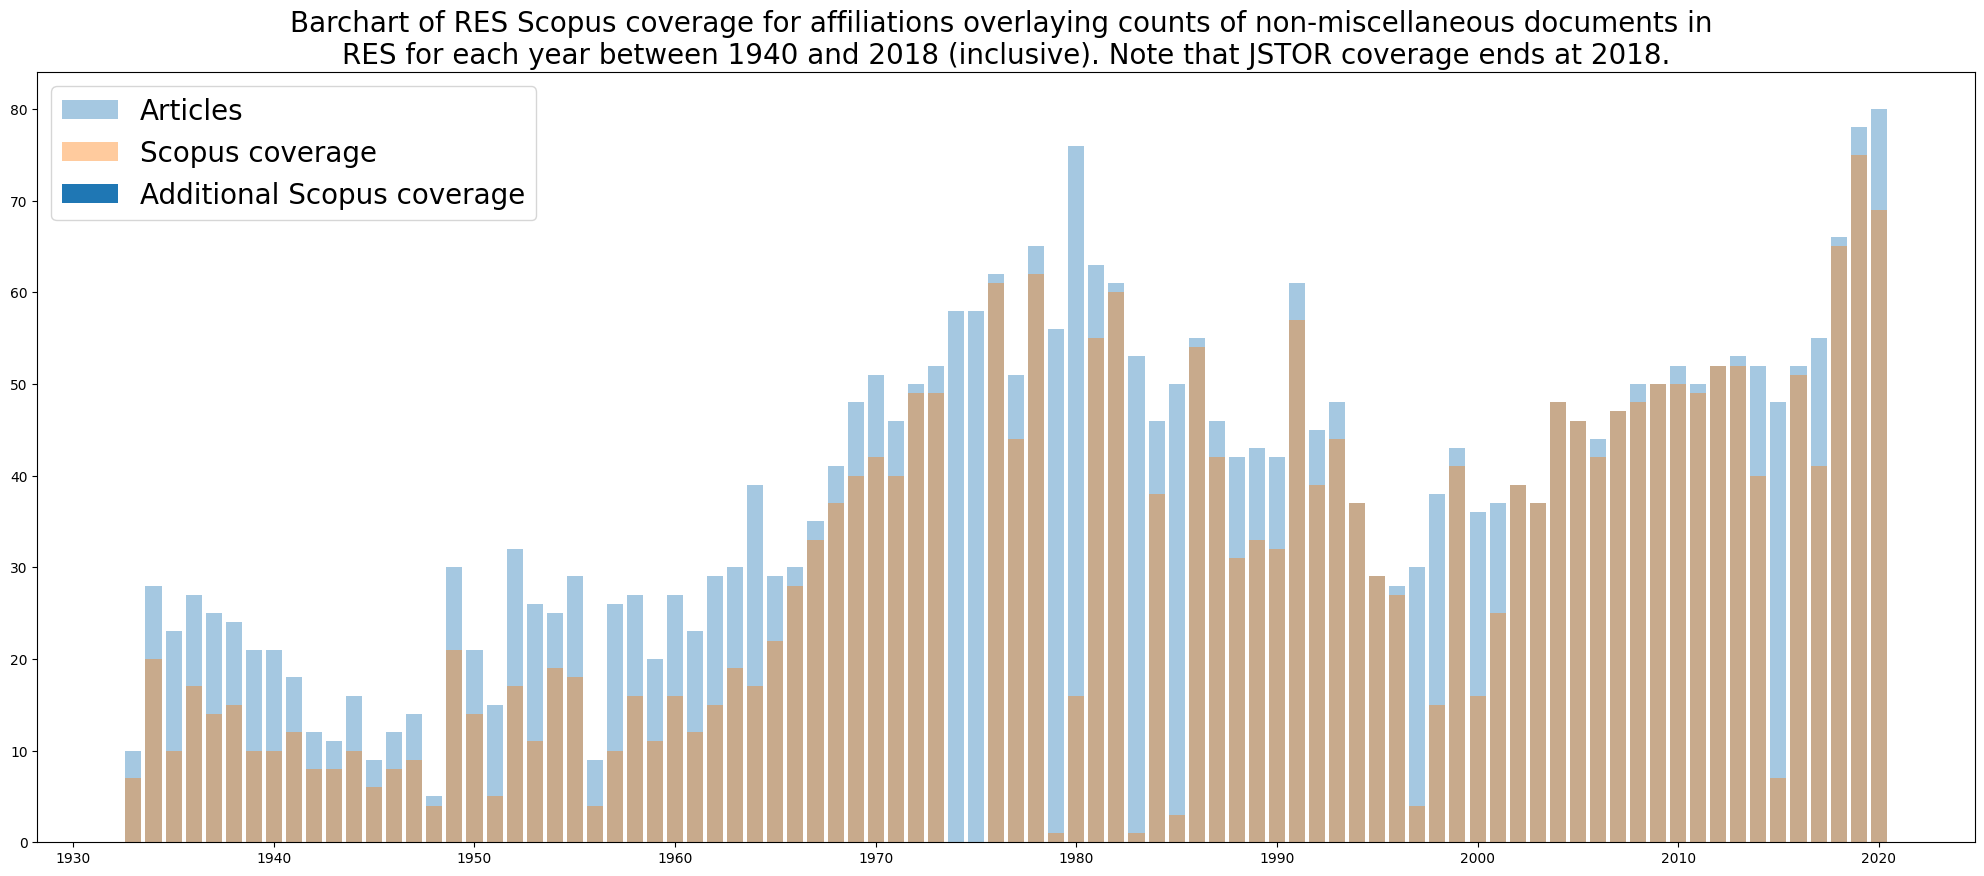

In [232]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of RES Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})


Some years of coverage are almost complete, it may not be necessary to use OCR to extract affiliations. I propose there's only a real point to set up the OCR if there if more than 80% of the articles in a issue are missing affiliations. 

Consider the missing counts of articles per issue by getting counts of total per issue and scopus affiliations per issue.

In [223]:
sc_aff=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','volume','number']].value_counts()
js_aff=Merged[(Merged['content_type']!='MISC')][['year','volume','number']].value_counts()

Create a dataframe of counts of missing article affiliations per issue and merge that with the total articles per issue and calculate the percentage of missing article affiliations.

In [236]:

difference=pd.merge(sc_aff.reset_index(), js_aff.reset_index(), on=['year', 'number','volume'], how='right').sort_values(['year','number','volume'])
difference['available_per']=difference['count_x']/difference['count_y']
difference.rename(columns = {'count_x':'available', 'count_y':'total'}, inplace = True)
difference['available_per'] = difference['available_per'].fillna(1)
difference = difference.fillna(0)

sum(difference["total"]-difference["available"]) # if missing is NaN that means the whole issue is missing.

916.0

There are on average 10 articles per issue. And for older papers, there are only 5 to 7 articles in the issue. Hence, if there are only one or two missing affiliations in that issue it makes sense to collect them manually since setting up the rules for OCR to find the affiliations in just one paper is more time consuming than looking it up.

In [231]:
check_aff=Merged[(Merged['content_type']!='MISC')&(Merged['year']>=1940)&(Merged['year']<=2010)] #restrict to 1940 to 2010
print(sum(check_aff['affiliations'].isnull())) #number of missing in time period
print(check_aff.shape[0]) #total articles in 1940 to 2010
print(1-(sum(check_aff['affiliations'].isnull())/check_aff.shape[0])) #percentage coverage
sum(difference[difference["year"]>1940]['missing']) #manual work expected

766
2680
0.714179104477612


511.0

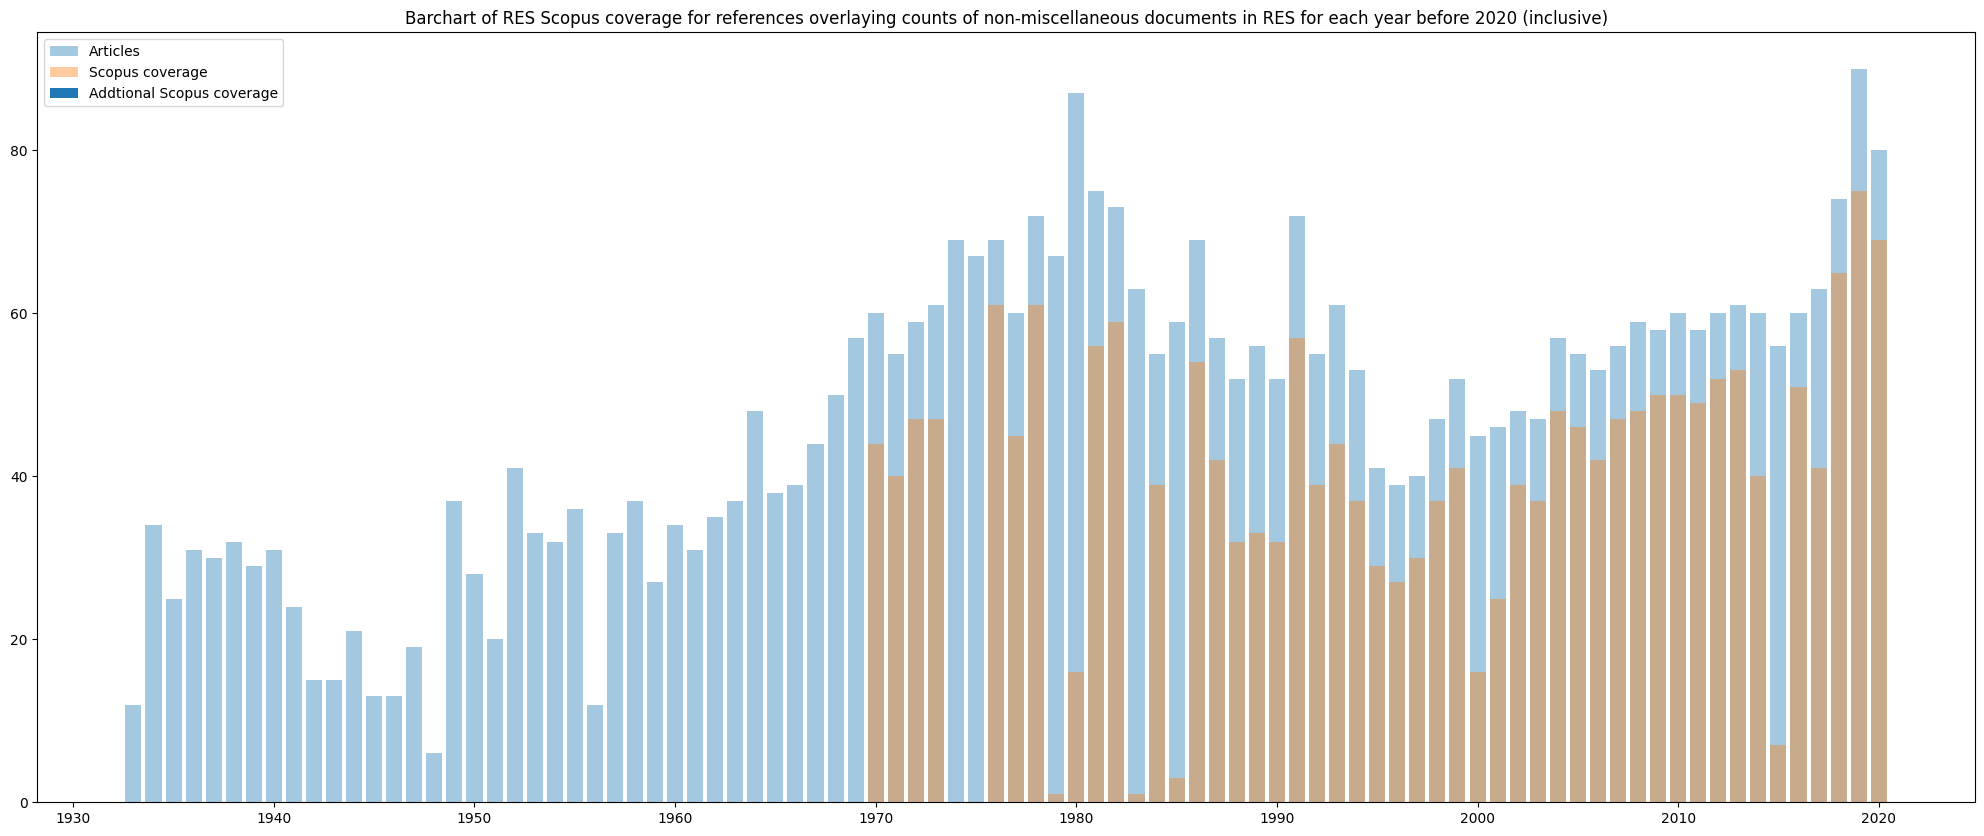

In [237]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of RES Scopus coverage for references overlaying counts of non-miscellaneous documents in RES for each year before 2020 (inclusive)')
plt.xticks(np.arange(1930, 2030, 10))
plt.legend()

In [270]:
check_ref=Merged[(Merged['content_type']!='MISC')&(Merged['year']>=1940)&(Merged['year']<=2010)] # restrict between 1940 and 2010
print(sum(check_aff['citations'].isnull())) # number of missing ref articles 
print(check_aff.shape[0]) # total number of articles
print(1-(sum(check_aff['citations'].isnull())/check_aff.shape[0])) #percentage coverage

1166
2681
0.5650876538604999
